In [1]:
import os, fiona, glob
import geopandas as gpd
import pandas as pd
from rasterio.crs import CRS
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
# Every time you change something within the code cell, run it once more to update the variable.

BOUNDS = [39.4799, -78.467, 38.393, -80.2704] # In decimal coordinate form.  Format: [N, E, S, W].  Select the smallest area possible in your analyses for maximum resoultion!  

API_KEY = '9086887f175d33aa72eda767f5b1e9cd' # Get your API key from opentopography.org.  Students get higher resolution data!

DEM_DATASET = 'USGS30m' # Options are USGS30m, USGS10m, & USGS1m.  Be warned!  As resolution goes up, available download area goes down.

PROJ_TITLE = 'wv_data' # Create a succinct name with no spaces or leading digits to represent your project file for future exports.

PATH = os.getcwd()

In [4]:
dir = f'{PATH}/{PROJ_TITLE}/GeoDatabases'
path_list = glob.glob(f'{dir}/*.zip')
master_dip_gdf = gpd.GeoDataFrame()
master_geol_gdf = gpd.GeoDataFrame()
for path in path_list:
    valid_layers = []
    try:
        layers = fiona.listlayers(path)
        for layer in layers:
            if 'BED' in layer:
                valid_layers.append(layer)
            if 'CNT_poly' in layer or 'CNT_POLY' in layer:
                valid_layers.append(layer)
            gdf = gpd.read_file(path, layer=valid_layers[0])
            gdf.columns = gdf.columns.str.lower()
            master_dip_gdf = pd.concat([master_dip_gdf, gdf], ignore_index=True)
            try:
                gdf2 = gpd.read_file(path, layer = valid_layers[1])
                gdf2.columns = gdf2.columns.str.lower()
                master_geol_gdf= pd.concat([master_geol_gdf, gdf2], ignore_index=True)
            except Exception as e:
                print(f'No geology layer, {e}')
    except Exception as e:
        print(f'An error occured: {e}')

An error occured: Failed to open dataset (flags=68): /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data/GeoDatabases/DDS-10_FrontRoyal100K_GeMS_lvl3.zip
An error occured: list index out of range
No geology layer, list index out of range
An error occured: Failed to open dataset (flags=68): /sciclone/home/ntlewis/Nick-Lewis-Research/working_files/jupyter_proto/wv_data/GeoDatabases/DDS-9_Cumberland100K_GeMS_Lvl3.zip
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
An error occured: list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geology layer, list index out of range
No geolog

<Axes: >

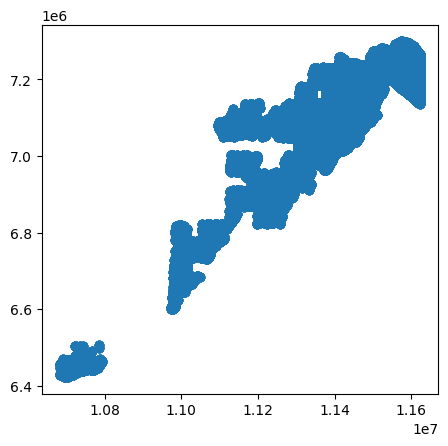

In [5]:
master_dip_gdf = master_dip_gdf[['dip_angle', 'dip_direct', "geometry"]].to_crs(CRS.from_epsg(2283))
master_dip_gdf.plot()

In [6]:
master_geol_gdf = master_geol_gdf[['unit_abbrv', 'geometry', 'symbol']].to_crs(CRS.from_epsg(2283))
display(master_geol_gdf)

,unit_abbrv,geometry,symbol
0,Dmt,"MULTIPOLYGON (((11574806.845 7300828.101, 1157...",NaN
1,Dbh,"MULTIPOLYGON (((11577427.749 7300346.097, 1157...",NaN
2,Dmn,"MULTIPOLYGON (((11534531.853 7209869.177, 1153...",NaN
3,Dbh,"MULTIPOLYGON (((11592212.912 7296278.82, 11592...",NaN
4,Do,"MULTIPOLYGON (((11534088.245 7210222.759, 1153...",NaN
...,...,...,...
16270,Dbh,"MULTIPOLYGON (((11423941.729 7182162.146, 1142...",NaN
16271,Dgg,"MULTIPOLYGON (((11430359.926 7180140.665, 1143...",NaN
16272,Dhs,"MULTIPOLYGON (((11434285.339 7174625.762, 1143...",NaN
16273,Dgg,"MULTIPOLYGON (((11439482.57 7177873.493, 11439...",NaN


In [7]:
from pyproj import Proj, transform
import numpy as np

kp_dip_fin = gpd.GeoDataFrame()
kp_geol_fin = gpd.GeoDataFrame()

ksn_paths = glob.glob(f'{PATH}/{PROJ_TITLE}/ksn_csvs/*.csv')
for csv in ksn_paths:
    csv_name = csv.split(sep='/')[-1]
    wshed_name = csv_name[0:-23]
    ksn_df = pd.read_csv(csv, index_col=0)
    delta_ksn = np.abs(np.asarray(ksn_df['delta_ksn']))
    high_ksn = [x > np.percentile(delta_ksn, 90) for x in delta_ksn]
    ksn_df['kp'] = high_ksn
    in_proj = Proj(init='epsg:2283')
    out_proj = Proj(init='epsg:4269')
    easting = ksn_df.x.values
    northing = ksn_df.y.values
    longitude, latitude = transform(in_proj, out_proj, easting, northing)
    ksn_df['longitude'] = longitude
    ksn_df['latitude'] = latitude
    ksn_df['wshed'] = [wshed_name]*len(ksn_df)
    ksn_df_masked = ksn_df[ksn_df.kp == True][['chi', 'delta_ksn', 'elevation', 'x', 'y', 'longitude', 'latitude', 'wshed']]
    final_kp_df = gpd.GeoDataFrame(data=ksn_df_masked, geometry= gpd.points_from_xy(ksn_df_masked.x, ksn_df_masked.y), crs=CRS.from_epsg(2283))
    kp_dip = gpd.sjoin_nearest(final_kp_df, master_dip_gdf, max_distance=300, distance_col='dist_from_dip')
    kp_geol = gpd.sjoin_nearest(final_kp_df, master_geol_gdf, max_distance=300, distance_col='dist_from_geol')
    kp_dip_fin = pd.concat([kp_dip_fin, kp_dip], ignore_index=True)
    kp_geol_fin = pd.concat([kp_geol, kp_geol_fin], ignore_index=True)


<Axes: xlabel='dip_angle', ylabel='Count'>

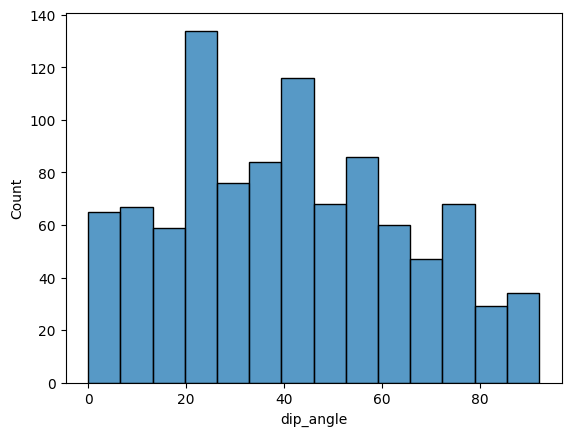

In [8]:
kp_dip_fin
sns.histplot(data=kp_dip_fin, x='dip_angle')

In [8]:
kp_geol_fin

,chi,delta_ksn,elevation,x,y,longitude,latitude,wshed,geometry,index_right,unit_abbrv,symbol,dist_from_geol
0,15.014900,43.446380,770.9517,11058562.0,6820139.0,-79.980150,38.367039,Sitlington_Creek-Greenbrier_River,POINT (11058562 6820139),8925,Mp,NaN,0.0
1,15.014900,43.446380,770.9517,11058562.0,6820139.0,-79.980150,38.367039,Sitlington_Creek-Greenbrier_River,POINT (11058562 6820139),8884,Mp,NaN,0.0
2,15.014900,43.446380,770.9517,11058562.0,6820139.0,-79.980150,38.367039,Sitlington_Creek-Greenbrier_River,POINT (11058562 6820139),8966,Mp,NaN,0.0
3,15.014900,43.446380,770.9517,11058562.0,6820139.0,-79.980150,38.367039,Sitlington_Creek-Greenbrier_River,POINT (11058562 6820139),9007,Mp,NaN,0.0
4,15.014900,43.446380,770.9517,11058562.0,6820139.0,-79.980150,38.367039,Sitlington_Creek-Greenbrier_River,POINT (11058562 6820139),8843,Mp,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993,7.085413,-28.477947,678.9214,11348109.0,7235948.5,-78.977795,39.517135,Georges_Creek,POINT (11348109 7235948.5),7474,,NaN,0.0
3994,7.085413,-28.477947,678.9214,11348109.0,7235948.5,-78.977795,39.517135,Georges_Creek,POINT (11348109 7235948.5),7108,,NaN,0.0
3995,7.085413,-28.477947,678.9214,11348109.0,7235948.5,-78.977795,39.517135,Georges_Creek,POINT (11348109 7235948.5),7413,,NaN,0.0
3996,7.085413,-28.477947,678.9214,11348109.0,7235948.5,-78.977795,39.517135,Georges_Creek,POINT (11348109 7235948.5),7169,,NaN,0.0
